# Отчёт по лабораторной работе

Задание: A-03 (OpenMP)  
Выполнил: Муравьев Илья Владимирович

## Условие

Написать программу вычисления матричного выражения:

$\mathbf{A} = \mathbf{B}\ \mathbf{C}^2 + M(\mathbf{C})\ \mathbf{I} + \mathbf{I} + D(\mathbf{B})\ \mathbf{E}$,

где $\mathbf{B}$, $\mathbf{C}$ – квадратные плотные матрицы, элементы которых имеют тип double, причем элементы матрицы $\mathbf{C}$ задаются с помощью генератора псевдослучайных чисел, $\mathbf{I}$ – единичная матрица, $\mathbf{E}$ – полностью заполненная матрица, все элементы которой равны единице, $M(\mathbf{C)}$ – среднее значений элементов матрицы $\mathbf{C}$, $D(\mathbf{C)}$ – дисперсия элементов матрицы $\mathbf{C}$. Распараллелить эту программу с помощью OpenMP (parallel, task). Исследовать зависимость масштабируемости параллельной версии программы от ее вычислительной трудоемкости (размера матриц).  
Проверить корректность параллельной версии.  
Проверка закона Амдала. Построить зависимость ускорение:число потоков для заданного примера.

## Программно-аппаратная конфигурация тестового стенда

In [1]:
!echo -n "OS: "; cat /etc/os-release | grep PRETTY_NAME | cut -d= -f2 | tr -d '"'
!echo -n "GCC Version: "; gcc --version | head -n 1
!echo -n "CPU Model: "; lscpu | grep "Model name" | awk -F: '{print $2}' | xargs
!echo -n "Logical Cores: "; lscpu | grep "^CPU(s):" | awk -F: '{print $2}' | xargs
!echo -n "Physical Cores: "; lscpu | grep "^Core(s) per socket:" | awk -F: '{print $2}' | xargs
!echo -n "RAM: "; free -h --si | awk '/Mem:/ {print $2}'

OS: Ubuntu 22.04.4 LTS
GCC Version: gcc (GCC) 10.2.0
CPU Model: Intel(R) Xeon(R) E-2136 CPU @ 3.30GHz
Logical Cores: 12
Physical Cores: 6
RAM: 64G


## Метод

Алгоритм решения:

- вычисление $M(\mathbf{C})$;
- вычисление $M(\mathbf{D})$;
- вычисление $\mathbf{C}^2$;
- вычисление $\mathbf{B}\ \mathbf{C}^2$;
- прибавление $1 + M(\mathbf{C})$ к каждому элементу главной диагонали $\mathbf{B}\ \mathbf{C}^2$;
- прибавление $D(\mathbf{B})$ к каждому элементу полученной на предыдущем шаге матрицы.

Для вычисления произведения матриц используется наивный алгоритм, основанный на определении произведения матриц $(\mathbf{A}\ \mathbf{B})_{i,j} = \sum_{k=1}^n \mathbf{A}_{i,k}\ \mathbf{B}^T_{j,k}$. Правый множитель транспонируется перед вычислением произведения, чтобы эффективнее использовать кэши процессора.

## Реализация

Решение реализовано на языке программирования C. При выполнении команды `make` собираются два исполняемых файла:

- `main` – решает поставленную задачу;
- `save_random_matrix` – генерирует случайные квадратные матрицы указанного размера.

При вычислении каждой матричной операции внешний цикл распараллеливается с помощью директивы OpenMP `parallel for`.

Реализация доступна в GitHub-репозитории: [https://github.com/IlyaMuravjov/openmp-task-a03](https://github.com/IlyaMuravjov/openmp-task-a03).

Данный отчёт сгенерирован из файла Python Notebook: [https://github.com/IlyaMuravjov/openmp-task-a03/blob/main/experiment.ipynb](https://github.com/IlyaMuravjov/openmp-task-a03/blob/main/experiment.ipynb).

## Эксперимент

В данном разделе приведены результаты экспериментов, призванных ответить на три исследовательских вопроса:

1. Корректно ли разработанная реализация работает в параллельном режиме?
2. Как разработанная реализация масштабируется при увеличении размера матриц?
3. Выполняется ли для разработанной реализации закон Амдала?

### Корректность

Результат запуска скрипта проверки соответствия результатов, полученных вручную, и результатов, полученных последовательной версией, для матрицы размера $2 \times 2$.

In [ ]:
%pip install matplotlib
%pip install nbconvert
%pip install pandas
%pip install scipy
%pip install tabulate

In [3]:
import subprocess
import re
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import filecmp

from getpass import getpass
from IPython.display import Markdown, display
from scipy.optimize import curve_fit

In [ ]:
subprocess.run(['make'], check=True)

In [5]:
# B = {{1,2},{3,4}}
# C = {{5,6},{7,8}}
# M(C) = 6.5
# D(B) = 1.25
# A = B*C^2 + M(C)*I + I + D(B)*E = {{257.75, 291.25}, {566.25, 666.75}}

subprocess.run(['./main', 'data/B_sample.txt', 'data/C_sample.txt', 'data/A_sample_actual.txt', '1'], stdout=subprocess.PIPE, text=True, check=True)
if (filecmp.cmp("data/A_sample_actual.txt", "data/A_sample_expected.txt")):
    print("Seqential version results match manually calculated results")
else:
    print("Seqential version results and manually calculated results diverged!")

Seqential version results match manually calculated results


Результат запуска скрипта проверки соответствия результатов, полученных последовательной и параллельной версиями, для матрицы размера $3000 \times 3000$.

In [6]:
def run_experiment(matrix_size, num_threads, seed=42, min_value=-1.0, max_value=1.0, data_dir = 'data'):
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    B_filename = os.path.join(data_dir, f'B_{matrix_size}.txt')
    C_filename = os.path.join(data_dir, f'C_{matrix_size}.txt')
    A_filename = os.path.join(data_dir, f'A_{matrix_size}_{num_threads}.txt')
    
    subprocess.run(['./save_random_matrix', B_filename, str(matrix_size), str(min_value), str(max_value), str(seed)], check=True)
    subprocess.run(['./save_random_matrix', C_filename, str(matrix_size), str(min_value), str(max_value), str(seed+1)], check=True)
    
    result = subprocess.run(['./main', B_filename, C_filename, A_filename, str(num_threads)], stdout=subprocess.PIPE, text=True)
    output = result.stdout
    
    match = re.search(r'Computation time: ([\d\.]+) seconds', output)
    if match:
        computation_time = float(match.group(1))
    else:
        raise RuntimeError("Failed to extract computation time")
    return computation_time, A_filename

In [7]:
_, seq_output = run_experiment(matrix_size=3000, num_threads=1)
_, par_output = run_experiment(matrix_size=3000, num_threads=64)
if (filecmp.cmp(seq_output, par_output)):
    print("Parallel version results match sequential version results")
else:
    print("Parallel and sequential results diverged!")

Parallel version results match sequential version results


### Масштабируемость

Здесь и далее время работы указывается без учёта времени генерации входных данных и времени, затраченного на операции ввода-вывода.

Результаты запуска скрипта оценки масштабируемости параллельной версии программы от её вычислительной трудоемкости (размера матриц) для матриц размера $N \times N$.

In [ ]:
sizes = list(range(2000, 7000, 600))
num_threads = 12

times_for_sizes = []
for size in sizes:
    time, _ = run_experiment(size, num_threads)
    times_for_sizes.append(time)
    print(f"N: {size}, time: {time:.6f} seconds")

In [9]:
display(Markdown(pd.DataFrame({
    'N': sizes,
    'Time (seconds)': times_for_sizes
}).round(2).to_markdown(index=False)))

|    N |   Time (seconds) |
|-----:|-----------------:|
| 2000 |             1.52 |
| 2600 |             3.27 |
| 3200 |             6.28 |
| 3800 |            10.42 |
| 4400 |            16.41 |
| 5000 |            24.43 |
| 5600 |            35.19 |
| 6200 |            48.77 |
| 6800 |            65.89 |

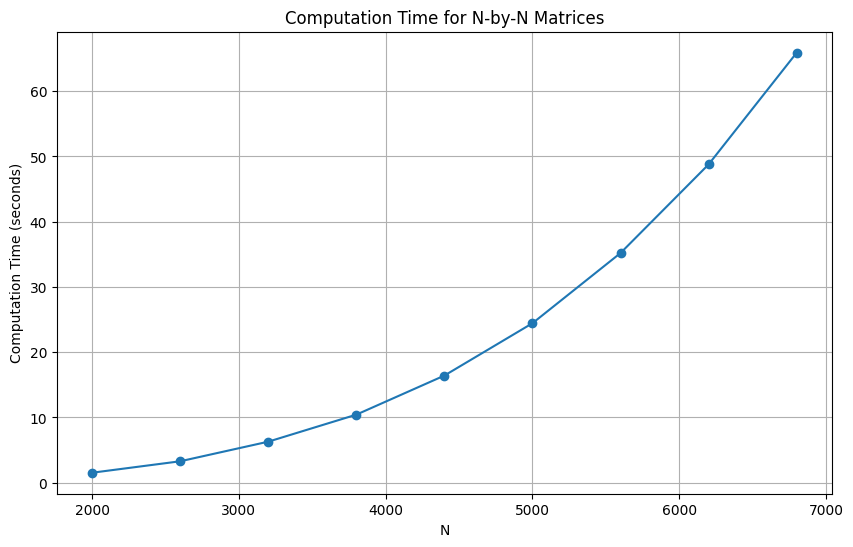

In [10]:
plt.figure(figsize=(10,6))

plt.plot(sizes, times_for_sizes, marker='o')
plt.title('Computation Time for N-by-N Matrices')
plt.xlabel('N')
plt.ylabel('Computation Time (seconds)')
plt.grid(True)

plt.show()

In [11]:
slope, _ = np.polyfit(np.log(sizes), np.log(times_for_sizes), deg=1)
print(f"Slope of a log-log plot: {slope:.2f}")

Slope of a log-log plot: 3.08


### Проверка закона Амдала

Результаты запуска скрипта проверки закона Амдала для матрицы размера $3000 \times 3000$.

In [ ]:
matrix_size = 3000
max_threads = 24

threads_list = list(range(1, max_threads+1))
times_for_threads = []

for num_threads in threads_list:
    time, _ = run_experiment(matrix_size, num_threads)
    times_for_threads.append(time)
    print(f'Number of threads: {num_threads}, time: {time:.6f} seconds')

In [13]:
base_time = times_for_threads[0]
speedups = [base_time / t for t in times_for_threads]

def amdahl_law(N, P):
    return 1 / ((1 - P) + P / N)

params, _ = curve_fit(amdahl_law, threads_list[:11], speedups[:11], bounds=(0, 1))
parallel_part = params[0]

predicted_speedups = [amdahl_law(N, parallel_part) for N in threads_list]

display(Markdown(pd.DataFrame({
    'Number of Threads': threads_list,
    'Measured Speedup': speedups,
    f"Amdahl's law (P={parallel_part:.4f})": predicted_speedups
}).round(2).to_markdown(index=False)))

|   Number of Threads |   Measured Speedup |   Amdahl's law (P=0.9917) |
|--------------------:|-------------------:|--------------------------:|
|                   1 |               1    |                      1    |
|                   2 |               1.96 |                      1.98 |
|                   3 |               2.91 |                      2.95 |
|                   4 |               3.87 |                      3.9  |
|                   5 |               4.79 |                      4.84 |
|                   6 |               5.66 |                      5.76 |
|                   7 |               6.62 |                      6.67 |
|                   8 |               7.55 |                      7.56 |
|                   9 |               8.47 |                      8.44 |
|                  10 |               9.39 |                      9.3  |
|                  11 |              10.14 |                     10.16 |
|                  12 |              10.3  |                     11    |
|                  13 |               9.32 |                     11.82 |
|                  14 |               9.12 |                     12.64 |
|                  15 |               8.47 |                     13.44 |
|                  16 |               8.3  |                     14.23 |
|                  17 |               7.99 |                     15.01 |
|                  18 |               7.58 |                     15.77 |
|                  19 |               7.4  |                     16.53 |
|                  20 |               7.04 |                     17.27 |
|                  21 |               6.58 |                     18.01 |
|                  22 |               6.77 |                     18.73 |
|                  23 |               6.81 |                     19.45 |
|                  24 |               6.2  |                     20.15 |

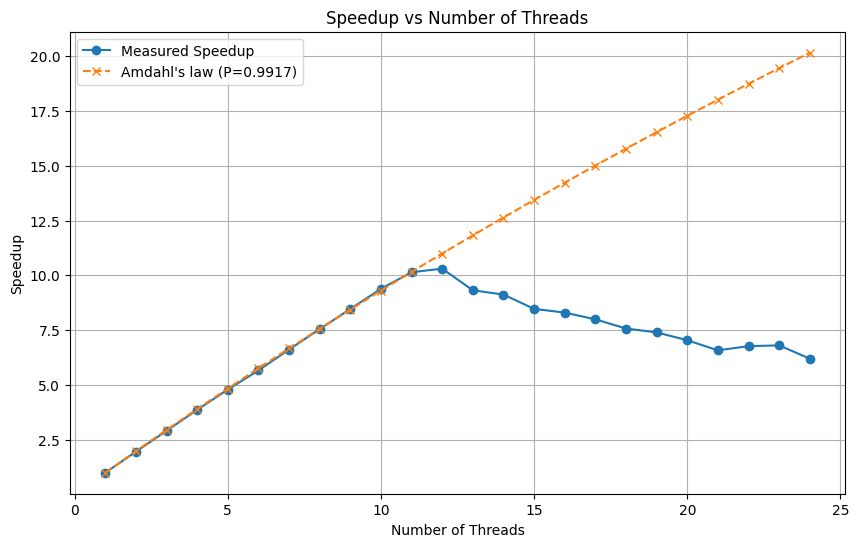

In [14]:
plt.figure(figsize=(10,6))
plt.plot(threads_list, speedups, marker='o', label='Measured Speedup')
plt.plot(threads_list, predicted_speedups, marker='x', linestyle='--', label=f"Amdahl's law (P={parallel_part:.4f})")
plt.title('Speedup vs Number of Threads')
plt.xlabel('Number of Threads')
plt.ylabel('Speedup')
plt.legend()
plt.grid(True)
plt.show()

## Выводы

Эмпирическим путём установлено, что:

- параллельная реализация работает корректно на рассмотренном примере;
- время работы параллельной реализации растёт примерно пропорционально $N^{3.08}$;
- закон Амдала выполняется для $P=0.9917$, когда число потоков меньше 12.

Объяснение расхождений с теорией:

- расхождение с теоретической оценкой сложности $\mathcal{O}(N^3)$ объясняется конечностью размера кэшей-процессора: с ростом размера матрицы всё меньшая часть матрицы помещается в кэши, что приводит к замедлению реализации;
- невыполнение закона Амдала при использовании более чем 12 потоков объяснятся тем, что используемый процессор имеет 12 логических потоков;
- небольшое отклонение от закона Амдала при 12 потоках объясняется тем, что часть процессорного времени тратится на выполнение фоновых задач.

In [66]:
# Save report, requires pandoc and no special characters in notebook outputs

!jupyter nbconvert --to markdown --no-input experiment.ipynb
!pandoc experiment.md -o report.pdf --pdf-engine=xelatex \
  -V mainfont="CMU Serif" \
  -V monofont="DejaVu Sans Mono" \
  -V colorlinks=true \
  -V linkcolor=blue \
  -V fontsize=14pt \
  -V documentclass=extarticle \
  -V geometry:margin=1in \
  -V lang=ru-ru \
  -fmarkdown-implicit_figures

[NbConvertApp] Converting notebook experiment.ipynb to markdown
[NbConvertApp] Support files will be in experiment_files/
[NbConvertApp] Writing 7070 bytes to experiment.md
